In [1]:
from google.colab import files
files.upload()

Saving Unemployment_Rate_upto_11_2020.csv to Unemployment_Rate_upto_11_2020.csv


{'Unemployment_Rate_upto_11_2020.csv': b'Region, Date, Frequency, Estimated Unemployment Rate (%), Estimated Employed, Estimated Labour Participation Rate (%),Region,longitude,latitude\r\nAndhra Pradesh, 31-01-2020, M,5.48,16635535,41.02,South,15.9129,79.7400\r\nAndhra Pradesh, 29-02-2020, M,5.83,16545652,40.9,South,15.9129,79.7400\r\nAndhra Pradesh, 31-03-2020, M,5.79,15881197,39.18,South,15.9129,79.7400\r\nAndhra Pradesh, 30-04-2020, M,20.51,11336911,33.1,South,15.9129,79.7400\r\nAndhra Pradesh, 31-05-2020, M,17.43,12988845,36.46,South,15.9129,79.7400\r\nAndhra Pradesh, 30-06-2020, M,3.31,19805400,47.41,South,15.9129,79.7400\r\nAndhra Pradesh, 31-07-2020, M,8.34,15431615,38.91,South,15.9129,79.7400\r\nAndhra Pradesh, 31-08-2020, M,6.96,15251776,37.83,South,15.9129,79.7400\r\nAndhra Pradesh, 30-09-2020, M,6.4,15220312,37.47,South,15.9129,79.7400\r\nAndhra Pradesh, 31-10-2020, M,6.59,15157557,37.34,South,15.9129,79.7400\r\nAssam, 31-01-2020, M,4.66,13051904,52.98,Northeast,26.2006,92.9

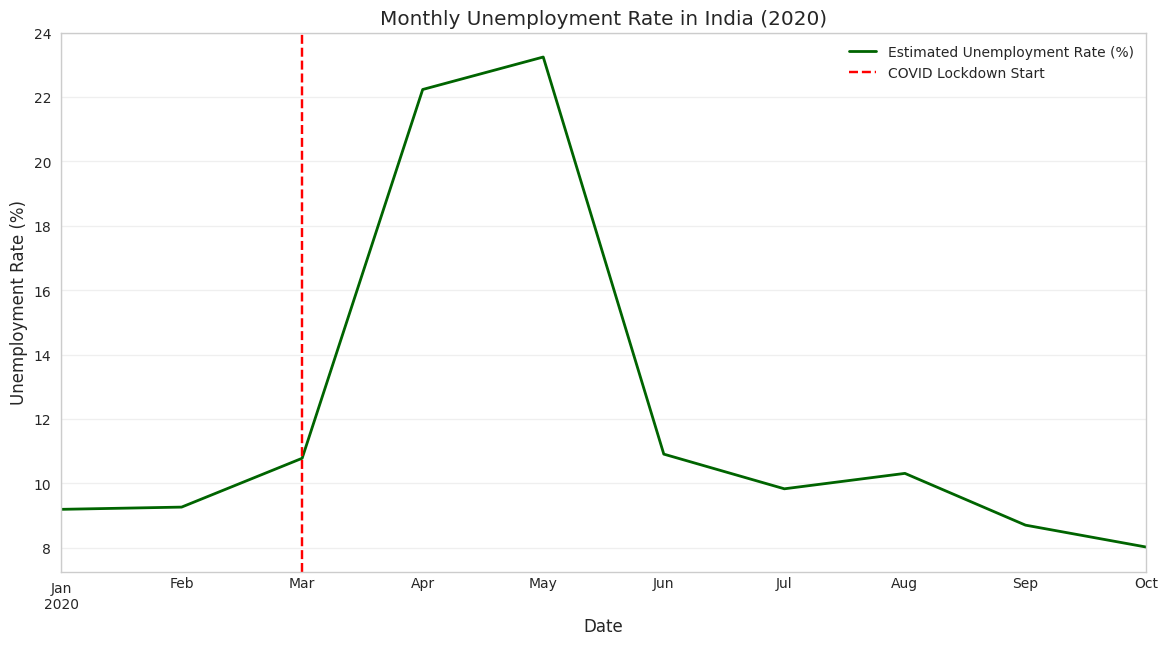

Top 5 Most Affected Regions:
Period      Pre-COVID  Post-COVID    Change
Region                                     
Puducherry       1.17    22.13500  20.96500
Tamil Nadu       1.83    14.77625  12.94625
Bihar           10.45    21.72625  11.27625
Jharkhand       11.23    21.61625  10.38625
Goa              5.85    13.74625   7.89625

Model Mean Absolute Error: 3.60 percentage points


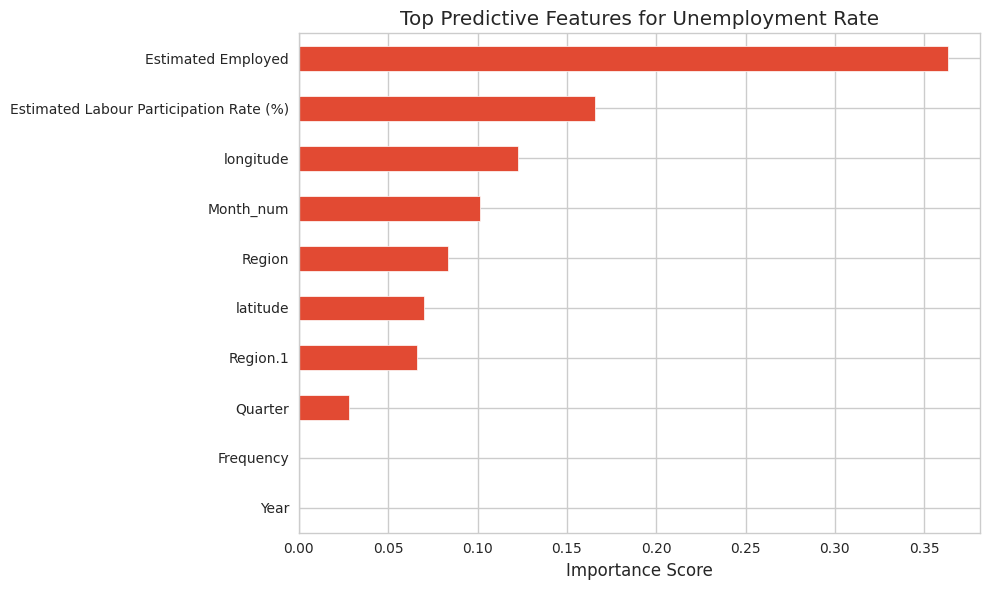

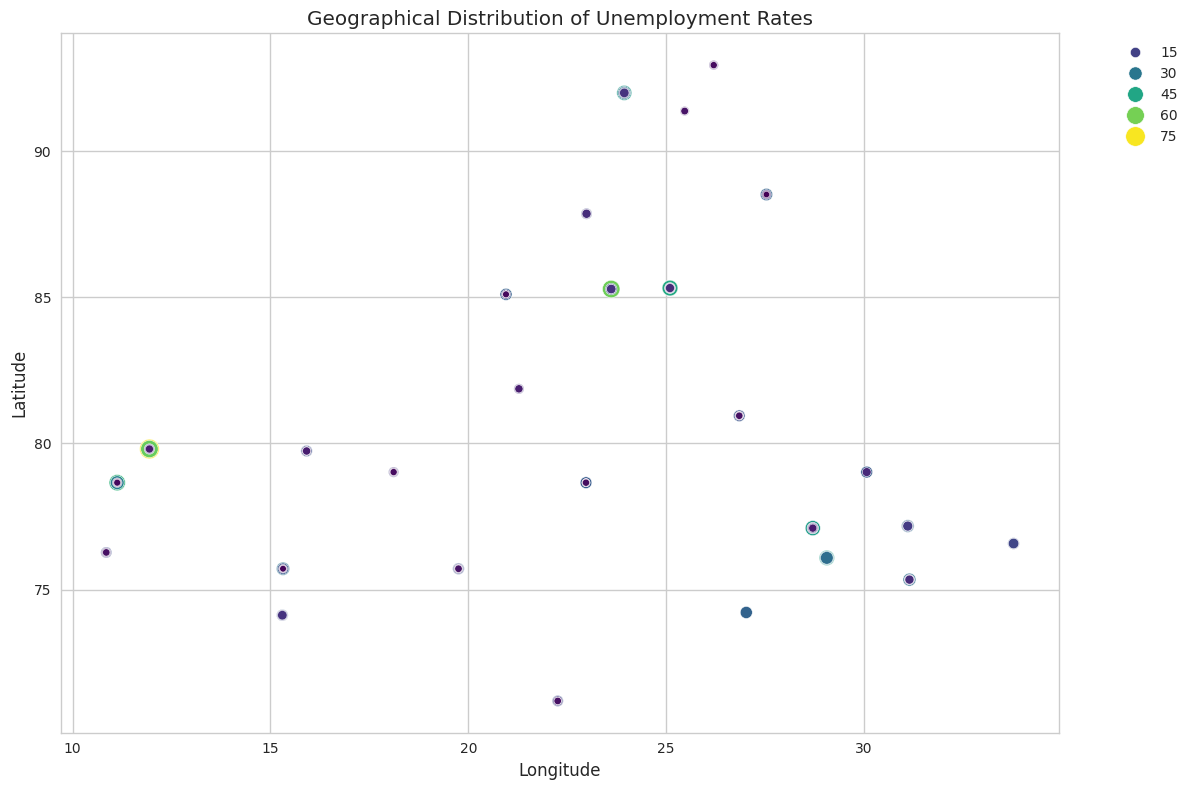

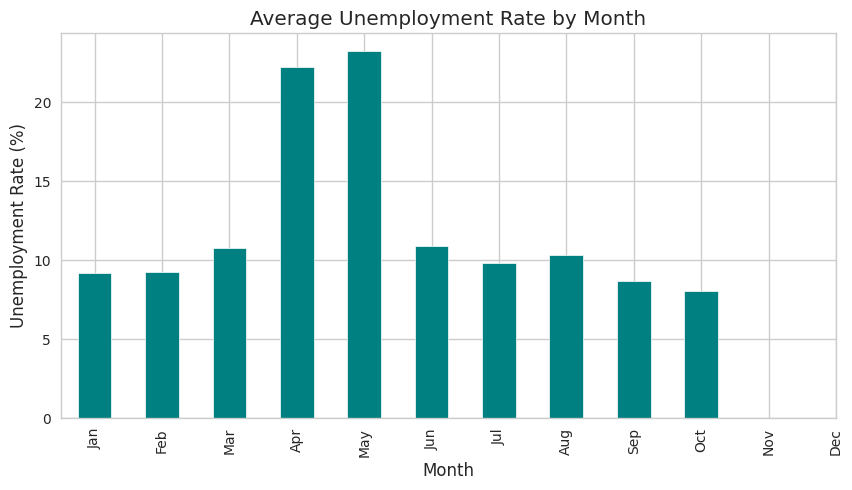

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
df = pd.read_csv('Unemployment_Rate_upto_11_2020.csv')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.drop_duplicates()
df['Month_num'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

monthly_unemployment = df.resample('ME', on='Date')['Estimated Unemployment Rate (%)'].mean()
plt.figure(figsize=(14, 7))
monthly_unemployment.plot(title='Monthly Unemployment Rate in India (2020)', color='darkgreen', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--',label='COVID Lockdown Start')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

df['Period'] = np.where(df['Date'] < '2020-03-01', 'Pre-COVID', 'Post-COVID')
covid_impact = df.groupby(['Region', 'Period'])['Estimated Unemployment Rate (%)'].mean().unstack()
covid_impact['Change'] = covid_impact['Post-COVID'] - covid_impact['Pre-COVID']
most_affected = covid_impact.sort_values('Change', ascending=False).head(5)
print("Top 5 Most Affected Regions:")
print(most_affected[['Pre-COVID', 'Post-COVID', 'Change']])

label_encoders = {}
categorical_cols = ['Region', 'Region.1', 'Frequency']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
features = ['Region', 'Region.1', 'Frequency', 'Estimated Employed','Estimated Labour Participation Rate (%)', 'longitude','latitude', 'Month_num', 'Year', 'Quarter']
X = df[features]
y = df['Estimated Unemployment Rate (%)']

split_date = pd.to_datetime('2020-08-01')
train = df[df['Date'] <= split_date]
test = df[df['Date'] > split_date]

X_train, X_test = train[features], test[features]
y_train, y_test = train['Estimated Unemployment Rate (%)'], test['Estimated Unemployment Rate (%)']
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"\nModel Mean Absolute Error: {mae:.2f} percentage points")
feature_importance = pd.Series(model.feature_importances_, index=features)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh')
plt.title('Top Predictive Features for Unemployment Rate')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='Estimated Unemployment Rate (%)',size='Estimated Unemployment Rate (%)', sizes=(20, 200),data=df, palette='viridis')
plt.title('Geographical Distribution of Unemployment Rates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

monthly_patterns = df.groupby('Month_num')['Estimated Unemployment Rate (%)'].mean()
plt.figure(figsize=(10, 5))
monthly_patterns.plot(kind='bar', color='teal')
plt.title('Average Unemployment Rate by Month')
plt.xlabel('Month')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()